# 하이퍼파라미터 튜닝 모듈화

## #01. 준비작업

### [1] 패키지 가져오기


In [8]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.tensor import *
from hossam.regression import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기


In [9]:
origin = my_read_excel("https://data.hossam.kr/mldata/fish.xlsx", info=False)


상위 5개 행
+----+--------+--------+--------+--------+
|    |   길이 |   높이 |   두께 |   무게 |
|----+--------+--------+--------+--------|
|  0 |    8.4 |   2.11 |   1.41 |    5.9 |
|  1 |   13.7 |   3.53 |      2 |     32 |
|  2 |     15 |   3.82 |   2.43 |     40 |
|  3 |   16.2 |   4.59 |   2.63 |   51.5 |
|  4 |   17.4 |   4.59 |   2.94 |     70 |
+----+--------+--------+--------+--------+


## #02. 데이터 전처리

### [1] 데이터 스케일링


In [10]:
df = my_minmax_scaler(data=origin, yname="무게")

my_pretty_table(data=df.head())

+----+----------+----------+-----------+--------+
|    |     길이 |     높이 |      두께 |   무게 |
|----+----------+----------+-----------+--------|
|  0 |        0 |        0 |         0 |    5.9 |
|  1 | 0.148876 | 0.132834 | 0.0876672 |     32 |
|  2 | 0.185393 | 0.159963 |   0.15156 |     40 |
|  3 | 0.219101 | 0.231993 |  0.181278 |   51.5 |
|  4 | 0.252809 | 0.231993 |   0.22734 |     70 |
+----+----------+----------+-----------+--------+


### [2] 훈련/검증 데이터 분할


In [11]:
x_train, x_test, y_train, y_test = my_train_test_split(df, "무게")
rows, cols = x_train.shape

## #03. 하이퍼파라미터 튜닝

### [1] 훈련 모델 적합

모듈화 된 기능으로부터 최적의 하이퍼파라미터가 셋팅된 model 객체를 리턴받는다.


In [12]:
model = tf_tune(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    layer=[
        {"units": [64, 32, 16, 8], "activation": "relu", "input_shape": (cols,)},
        {"units": [32, 16, 8, 4], "activation": "relu"},
        {"units": 1, "activation": "linear"},
    ],
    optimizer="adam",
    loss="mse",
    metrics=["mae"],
    learning_rate=[0.01, 0.001, 0.0001],
)

model.summary()

Trial 12 Complete [00h 00m 02s]
val_mae: 348.4692077636719

Best val_mae So Far: 346.3475646972656
Total elapsed time: 00h 00m 20s


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### [2] 최적 모델에 대한 학습 및 결과 확인


+-------+---------+---------+
|       |    loss |     mae |
|-------+---------+---------|
| train | 57033.2 |  215.06 |
| test  | 28471.1 | 164.678 |
+-------+---------+---------+


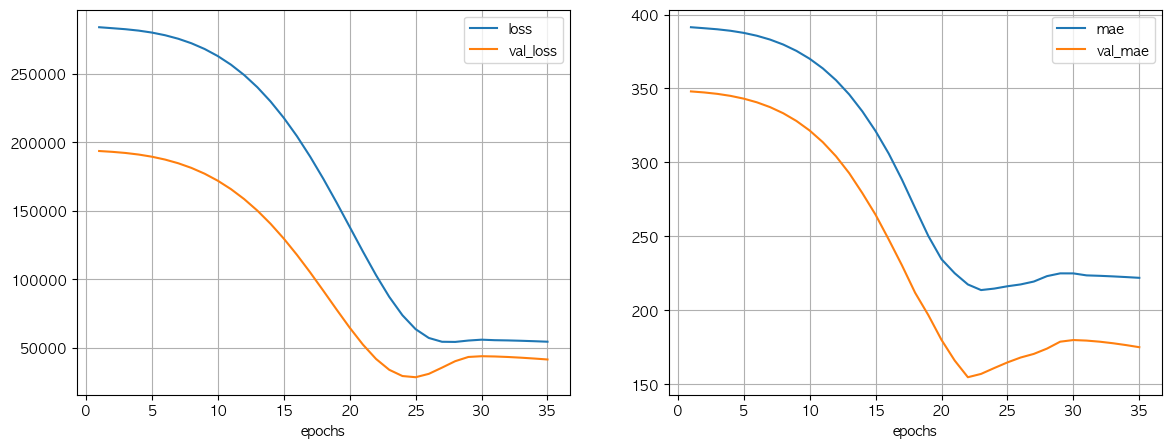

In [13]:
result = tf_train(
    model=model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

tf_result(result=result)

## #04. 모델 생성 + 학습 + 성능평가 일괄 처리

### [1] 범용 기능


Trial 12 Complete [00h 00m 02s]
val_mae: 348.4692077636719

Best val_mae So Far: 346.3475646972656
Total elapsed time: 00h 00m 23s
+-------+---------+---------+
|       |    loss |     mae |
|-------+---------+---------|
| train | 57033.2 |  215.06 |
| test  | 28471.1 | 164.678 |
+-------+---------+---------+


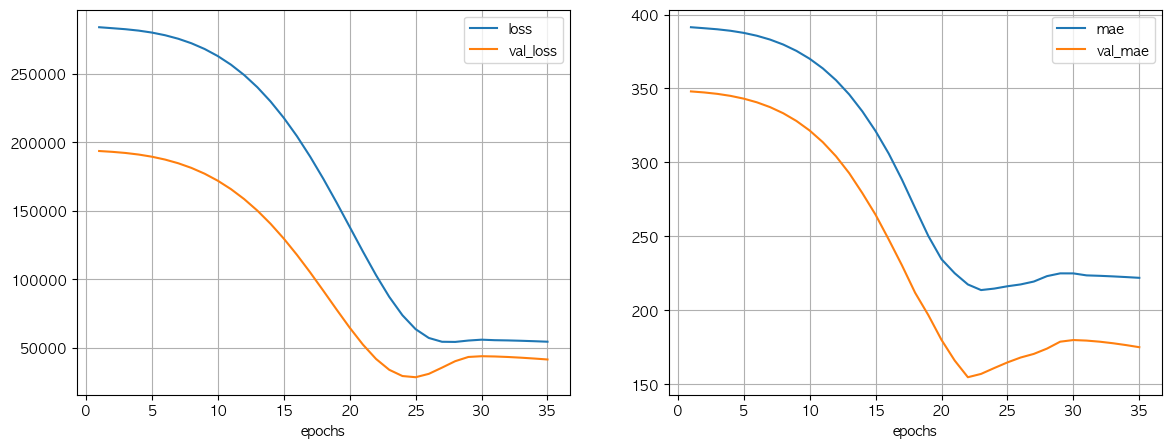

<Sequential name=sequential_1, built=True>

In [16]:
my_tf(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    layer=[
        {"units": [64, 32, 16, 8], "activation": "relu", "input_shape": (cols,)},
        {"units": [32, 16, 8, 4], "activation": "relu"},
        {"units": 1, "activation": "linear"},
    ],
    optimizer="adam",
    loss="mse",
    metrics=["mae"],
    learning_rate=[0.01, 0.001, 0.0001],
    tune=True,
)

### [2] 선형 회귀 맞춤 기능

하이퍼의 기본 값을 함수 정의에서 설정하고 있다.


Trial 15 Complete [00h 00m 02s]
val_mae: 343.6243591308594

Best val_mae So Far: 343.6243591308594
Total elapsed time: 00h 00m 27s


+-------+---------+---------+
|       |    loss |     mae |
|-------+---------+---------|
| train | 55194.6 | 215.129 |
| test  | 28886.6 | 165.438 |
+-------+---------+---------+


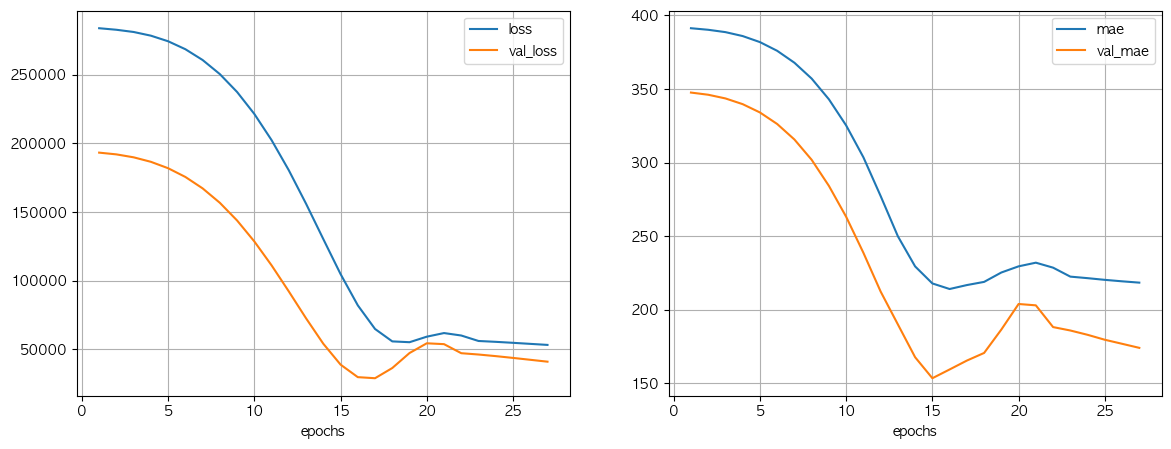

<Sequential name=sequential_1, built=True>

In [15]:
my_tf_linear(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
)